In [2]:
# Import necessary libraries
import os
import logging

# data processing
import duckdb
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from shapely.validation import make_valid
from typing import Optional, List, Dict, Tuple


# viz
from keplergl import KeplerGl
from IPython.display import IFrame
import matplotlib.pyplot as plt

> 🤔 
>
> The files for the population are massive, we will probably encounter issue loading them.
> The best approach is to filter the data beforehand and to create a smaller file with
>
> Let's use duckdb 🦆

# Data Gathering

In [39]:
# import and install spatial extension to duckDB
duckdb.sql('INSTALL spatial')
duckdb.sql('LOAD spatial')

### 🎡 Vienna

In [40]:
# load vienna districts in a table directly from shp
query = """
CREATE TABLE IF NOT EXISTS
  wien_districts AS
SELECT
  ST_Transform ( -- reproject the data
    ST_FlipCoordinates (geom), -- y,x -> x,y for crs reprojection 
    'EPSG:31256',
    'EPSG:4326'
  ) AS geom
FROM 
    ST_Read('/vsizip/data/vienna_districts.zip/BEZIRKSGRENZEOGDPolygon.shp');
SELECT count(*) FROM wien_districts;
"""

duckdb.sql(query)

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│           23 │
└──────────────┘

In [41]:
# you can describe a file easily
query = """
DESCRIBE TABLE './data/austria_pop.csv'
"""

duckdb.sql(query)

┌──────────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│   column_name    │ column_type │  null   │   key   │ default │  extra  │
│     varchar      │   varchar   │ varchar │ varchar │ varchar │ varchar │
├──────────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ longitude        │ DOUBLE      │ YES     │ NULL    │ NULL    │ NULL    │
│ latitude         │ DOUBLE      │ YES     │ NULL    │ NULL    │ NULL    │
│ aut_general_2020 │ DOUBLE      │ YES     │ NULL    │ NULL    │ NULL    │
└──────────────────┴─────────────┴─────────┴─────────┴─────────┴─────────┘

In [42]:
# load austrian population in table directly from csv  
query = """
DROP TABLE IF EXISTS austria_pop;
CREATE TABLE
  austria_pop AS
SELECT
  *
FROM
  read_csv ('./data/austria_pop.csv');
SELECT COUNT(aut_general_2020) FROM austria_pop;
"""

duckdb.sql(query)

┌─────────────────────────┐
│ count(aut_general_2020) │
│          int64          │
├─────────────────────────┤
│                17034412 │
└─────────────────────────┘

In [43]:
# select and export Vienna's population 
query = """
COPY (
  SELECT
    pop.longitude AS lon, pop.latitude AS lat, pop.aut_general_2020 AS pop
  FROM
    austria_pop pop
  JOIN wien_districts bzk ON -- allow to filter only the population in vienna
    ST_Intersects (
      bzk.geom,
      ST_Point2D (pop.latitude, pop.longitude) -- create geometry from csv
    )
) TO 'data/vienna_pop.parquet' (FORMAT 'parquet');
"""

duckdb.sql(query)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [44]:
# duckdb allows you to compute statistics blazing fast
# count total pop in Vienna
query = """
SELECT
  SUM(aut_general_2020)
FROM
  austria_pop pop
JOIN wien_districts bzk ON ST_Intersects(
    bzk.geom,
    ST_Point2D(pop.latitude, pop.longitude)
  )
"""

duckdb.sql(query)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────────────┐
│ sum(aut_general_2020) │
│        double         │
├───────────────────────┤
│     1919005.120881021 │
└───────────────────────┘

### 🥨 Berlin

In [13]:
# load german district in an in-memory table directly from geojson
query = """
CREATE TABLE IF NOT EXISTS
  berlin_districts AS
SELECT
  *
FROM
  ST_Read('data/berlin_districts.geojson');
SELECT COUNT(*) FROM berlin_districts;
"""

duckdb.sql(query)

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│           12 │
└──────────────┘

In [14]:
query = """
DESCRIBE TABLE 'data/germany_pop.csv'
"""

duckdb.sql(query)

┌─────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│ column_name │ column_type │  null   │   key   │ default │  extra  │
│   varchar   │   varchar   │ varchar │ varchar │ varchar │ varchar │
├─────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ Lat         │ DOUBLE      │ YES     │ NULL    │ NULL    │ NULL    │
│ Lon         │ DOUBLE      │ YES     │ NULL    │ NULL    │ NULL    │
│ Population  │ DOUBLE      │ YES     │ NULL    │ NULL    │ NULL    │
└─────────────┴─────────────┴─────────┴─────────┴─────────┴─────────┘

In [15]:
# load german population in table directly from csv  
query = """
CREATE TABLE IF NOT EXISTS
  german_pop AS
SELECT
  *
FROM
  read_csv ('./data/germany_pop.csv');
SELECT COUNT(*) FROM german_pop;
"""

duckdb.sql(query)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│     32446528 │
└──────────────┘

In [16]:
# select and export berlin population
query = """
COPY (
  SELECT
    pop.Lon AS lon, pop.Lat AS lat, pop.Population AS pop
  FROM
    german_pop pop
    JOIN berlin_districts bzk ON ST_Intersects (bzk.geom, ST_Point2D (pop.Lon, pop.Lat))
) TO 'data/berlin_pop.parquet' (FORMAT 'parquet');
"""

duckdb.sql(query)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [17]:
# you can also load a parquet file to do some calculation
query = """
SELECT
  SUM(pop)
FROM
  read_parquet('./data/berlin_pop.parquet');
"""

duckdb.sql(query)

┌────────────────────┐
│      sum(pop)      │
│       double       │
├────────────────────┤
│ 3341226.8634521104 │
└────────────────────┘

# Data Handler: Preparation, Cleaning, Filtering, and Analysis

> 💡 Tech Tip
>
> We will create a class because we will have to apply the same logic on two different cities. 
> Classes (or functions) are helpful for reusability, maintainability, and scalability.

In [3]:
# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] %(message)s',
    handlers=[
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

In [4]:
class CityGreenSpaceAnalysis:
    """
    A class to perform green space analysis for a given city.

    Attributes:
        city_name (str): Name of the city (e.g., 'Vienna', 'Berlin').
        BUFFER_DISTANCE (int): Buffer distance in meters around green spaces.
        REQUIRED_COLUMNS (Dict[str, Tuple[str, ...]]): Required columns for each GeoDataFrame.
    """    
    
    REQUIRED_COLUMNS: Dict[str, Tuple[str, ...]] = {
        'gdf_pop': ('pop',),
        'gdf_greens': ('green_id',),
        'gdf_districts': ('district_id', 'district_name')
    }
    BUFFER_DISTANCE =500
    
    def __init__(self, 
         city_name: str,
         buffer_distance: int
    ):
        """
        Initializes the analysis class with city name and buffer distance.

        Parameters:
            city_name (str): Name of the city.
            buffer_distance (int): Buffer distance in meters around green spaces.
        """
        self.city_name: str = city_name,
        self.BUFFER_DISTANCE: int = buffer_distance  
    
    # DATA GATHERING 

    def load_data(self, filepath:str, colx:str='x', coly:str='y') -> gpd.GeoDataFrame:
        """
        Loads data from a filepath into a GeoDataFrame.
        Automatically detects the type of data to load based on the file extension.

        Parameters:
            filepath (str): Path or URL to the data file.
            colx (str): Column name for the x-coordinate (used for parquet files).
            coly (str): Column name for the y-coordinate (used for parquet files).

        Returns:
            gpd.GeoDataFrame: Loaded GeoDataFrame.

        Raises:
            FileNotFoundError: If the file does not exist locally.
            ValueError: If the file format is not supported.
        """
        logger.info(f"Loading data for {self.city_name} from {filepath}...")

        # determine if the filepath is a URL or a local file
        if filepath.startswith('http'):
            full_path = filepath
        else:
            full_path = os.path.abspath(filepath)
            if not os.path.isfile(full_path):
                logger.error(f"File not found at: {full_path}")
                raise FileNotFoundError(f"File not found at: {full_path}")

        # supported file formats
        supported_geodata_formats = ('.zip', '.shp', '.geojson', '.json')
        if full_path.endswith(supported_geodata_formats) or filepath.startswith('http'):
            try:
                gdf = gpd.read_file(full_path)
                gdf = self._enforce_valid_gdf(gdf)
                logger.info(f"Loaded GeoDataFrame with {gdf.shape[0]} records.")
                return gdf
            except Exception as e:
                logger.error(f"Error loading GeoDataFrame: {e}")
                raise

        elif full_path.endswith('.parquet'):
            try:
                df = pd.read_parquet(full_path)
                geometry = [Point(xy) for xy in zip(df[colx], df[coly])]
                gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
                gdf = self._enforce_valid_gdf(gdf)
                logger.info(f"Loaded Parquet file with {gdf.shape[0]} records.")
                return gdf
            except Exception as e:
                logger.error(f"Error loading Parquet file: {e}")
                raise

        else:
            logger.error(f"Unsupported file format: {full_path}")
            raise ValueError(f"File format not supported: {full_path}")

    # ANALYSIS MAIN 

    def run_density_analysis(
        self,
        gdf_districts: gpd.GeoDataFrame,
        gdf_greens: gpd.GeoDataFrame,
        gdf_pop: gpd.GeoDataFrame
    ) -> gpd.GeoDataFrame:
        """
        Executes the full analysis pipeline.

        Parameters:
            gdf_districts (gpd.GeoDataFrame): GeoDataFrame of districts.
            gdf_greens (gpd.GeoDataFrame): GeoDataFrame of green spaces.
            gdf_pop (gpd.GeoDataFrame): GeoDataFrame of population points.

        Returns:
            gpd.GeoDataFrame: Aggregated and normalized GeoDataFrame of districts.
        """
        self._validate_columns(gdf_pop, gdf_greens, gdf_districts)

        # start analysis
        gdf_greens = self.buffer_green_spaces(gdf_greens, gdf_districts)
        gdf_pop = self.assign_pop_to_districts(gdf_pop, gdf_districts)
        gdf_pop = self.determine_proximity_to_green(gdf_pop, gdf_greens)
        gdf_districts = self.aggregate_pop_data(gdf_pop, gdf_districts)
        gdf_districts = self.normalize_pop_data(gdf_districts)

        logger.info("Analysis completed successfully.")
        return gdf_districts

    def run_2sfca_analysis(
        self,
        gdf_districts: gpd.GeoDataFrame,
        gdf_greens: gpd.GeoDataFrame,
        gdf_pop: gpd.GeoDataFrame
    ) -> gpd.GeoDataFrame:
        """
        Executes Two-Step Floating Catchment Area analysis pipeline.

        Parameters:
            gdf_districts (gpd.GeoDataFrame): GeoDataFrame of districts.
            gdf_greens (gpd.GeoDataFrame): GeoDataFrame of green spaces.
            gdf_pop (gpd.GeoDataFrame): GeoDataFrame of population points.

        Returns:
            gpd.GeoDataFrame: Aggregated and normalized GeoDataFrame of districts with accessibility scores.
        """
        self._validate_columns(gdf_pop, gdf_greens, gdf_districts)

        # Ensure 'pop_id' exists if not add it as index
        if 'pop_id' not in gdf_pop.columns:
            gdf_pop = gdf_pop.reset_index(drop=True)
            gdf_pop.insert(0, 'pop_id', gdf_pop.index + 1)
            logger.info("Added 'pop_id' column to population GeoDataFrame.")
            
        # start analysis
        gdf_greens = self.buffer_green_spaces(gdf_greens, gdf_districts)
        gdf_greens = self.calculate_supply_to_demand(gdf_greens, gdf_pop)
        gdf_districts = self.aggregate_accessibility(gdf_pop, gdf_greens, gdf_districts)

        logger.info("Two-Step Floating Catchment Area (2SFCA) analysis completed successfully.")
        return gdf_districts
        
    # METHODS FILTERING CLEANING & PROCESSING
    
    def buffer_green_spaces(
        self,
        gdf_greens: gpd.GeoDataFrame,
        gdf_districts: gpd.GeoDataFrame,
        buffer: Optional[int] = None
    ) -> gpd.GeoDataFrame:
        """
        Creates a buffer around green spaces. clip the geometry with the city districts.

        Parameters:
            gdf_greens (gpd.GeoDataFrame): GeoDataFrame of green spaces.
            gdf_districts (gpd.GeoDataFrame): GeoDataFrame of districts.
            buffer (Optional[int]): Buffer distance in meters. If not provided, uses the instance's buffer_distance.

        Returns:
            gpd.GeoDataFrame: GeoDataFrame with buffered geometries.
        """
        if buffer is not None:
            self.BUFFER_DISTANCE = buffer
            logger.debug(f"Buffer distance set to {self.BUFFER_DISTANCE} meters.")

        # project to a metric CRS for accurate buffering
        gdf_greens['buffered_geometry'] = (
            gdf_greens['geometry']
            .to_crs('EPSG:3857')
            .buffer(self.BUFFER_DISTANCE)
            .to_crs('EPSG:4326')
        )

        logger.info(f"Buffered green spaces with distance {self.BUFFER_DISTANCE} meters.")

        # clip geometries with districts
        gdf_greens['buffered_geometry'] = gpd.clip(gdf_greens['buffered_geometry'], gdf_districts['geometry'].unary_union)

        return gdf_greens

    def assign_pop_to_districts(
        self,
        gdf_pop: gpd.GeoDataFrame,
        gdf_districts: gpd.GeoDataFrame,
        geometry_column: str = 'geometry',
        district_id_column: str = 'district_id',
        district_name_column: str = 'district_name',
        columns_names: Optional[List[str]] = None
    ) -> gpd.GeoDataFrame:
        """
        Assigns each population point to its corresponding district via spatial join.

        Parameters:
            gdf_pop (gpd.GeoDataFrame): GeoDataFrame of population points.
            gdf_districts (gpd.GeoDataFrame): GeoDataFrame of districts.
            geometry_column (str): Column name for the geometry.
            district_id_column (str): Column name for district ID.
            district_name_column (str): Column name for district name.
            columns_names (Optional[List[str]]): Columns to enforce uniqueness.

        Returns:
            gpd.GeoDataFrame: GeoDataFrame with population assigned to districts.
        """
        gdf_pop = gdf_pop.reset_index(drop=True)
        gdf_districts = gdf_districts.reset_index(drop=True)

        if columns_names is None:
            columns_names = gdf_pop.columns.to_list()
        
        # spatial join
        gdf_pop = gpd.sjoin(
            gdf_pop, 
            gdf_districts[[district_id_column, district_name_column, geometry_column]], 
            how ='left', 
            predicate='within'
        )
        # drop the index_right column resulting from the join
        gdf_pop = gdf_pop.drop(columns=['index_right'])

        agg_dict = {col: 'first' for col in gdf_pop.columns}
        # group by function tend to tranform gdf in df -> rebuild gdf 
        df_pop = gdf_pop.groupby(gdf_pop.index).agg(
            agg_dict
        ).reset_index()
        gdf_pop = gpd.GeoDataFrame(df_pop, geometry='geometry', crs = gdf_pop.crs)

        # log the number of unassigned population points
        unassigned = gdf_pop[district_id_column].isna().sum()
        if unassigned > 0:
            logger.warning(f"Dropping {unassigned} unassigned population points.")
            gdf_pop = gdf_pop.dropna(subset=[district_id_column])

        return gdf_pop

    def determine_proximity_to_green(
        self,
        gdf_pop: gpd.GeoDataFrame,
        gdf_greens: gpd.GeoDataFrame,
        column_green_id: str = 'green_id',
        geometry_column: str = 'buffered_geometry',
        columns_names: Optional[List[str]] = None
    ) -> gpd.GeoDataFrame:
        """
        Determines if population points are within buffer distance to green spaces.

        Parameters:
            gdf_pop (gpd.GeoDataFrame): GeoDataFrame of population points.
            gdf_greens (gpd.GeoDataFrame): GeoDataFrame of buffered green spaces.
            column_green_id (str): Column name of the green spaces id
            geometry_column (str): Column name for buffered geometries.
            columns_names (Optional[List[str]]): Columns to enforce uniqueness.

        Returns:
            gpd.GeoDataFrame: GeoDataFrame with proximity information.
        """
        if columns_names is None:
            columns_names = gdf_pop.columns.to_list()

        # spatial join to find points within buffered green spaces
        gdf_pop = gpd.sjoin(
            gdf_pop, 
            gdf_greens[[column_green_id, geometry_column]].set_geometry(geometry_column), 
            how='left', 
            predicate='within'
        )

        # create a boolean column indicating proximity
        gdf_pop['within_500m_green'] = gdf_pop[column_green_id].notna()

        # drop the index_right column
        gdf_pop = gdf_pop.drop(columns=['index_right'])
        
        agg_dict = {col: 'first' for col in gdf_pop.columns}
        # group by function tend to tranform gdf in df -> rebuild gdf 
        df_pop = gdf_pop.groupby(gdf_pop.index).agg(
            agg_dict
        ).reset_index()
        gdf_pop = gpd.GeoDataFrame(df_pop, geometry='geometry', crs = gdf_pop.crs)        
        
        logger.info("Determined proximity of population points to green spaces.")
        return gdf_pop

    
    def calculate_supply_to_demand(
        self,
        gdf_greens: gpd.GeoDataFrame,
        gdf_pop: gpd.GeoDataFrame, 
        buffer: Optional[int] = None,
        geometry_column: str = 'buffered_geometry'
    ):
        """
        Calculate the supply/demand ratio of each green space.

        Parameters:
            gdf_greens (gpd.GeoDataFrame): GeoDataFrame of buffered green spaces.
            gdf_pop (gpd.GeoDataFrame): GeoDataFrame of population points.
            buffer (Optional[int]): Buffer distance in meters.
            geometry_column (str): Column name for buffered geometries.

        Returns:
            gpd.GeoDataFrame: GeoDataFrame with supply/demand ratio information.
        """
        if buffer is not None:
            self.BUFFER_DISTANCE = buffer
            logger.debug(f"Buffer distance set to {self.BUFFER_DISTANCE} meters.")

        # assign supply default value = area
        gdf_greens['supply'] = gdf_greens.to_crs('EPSG:3857').area
        
        # calculate total population within each buffer
        logger.info("Calculating total population within each green space buffer.")
        gdf_greens['total_pop_within_buffer'] = gdf_greens[geometry_column].apply(
            lambda geom: gdf_pop[gdf_pop['geometry'].within(geom)]['pop'].sum()
        )
        
        # handle division by zero
        gdf_greens['total_pop_within_buffer'] = gdf_greens['total_pop_within_buffer'].replace({0: 1e-6})
        
        # calculate supply-to-demand ratio
        gdf_greens['supply_to_demand_ratio'] = gdf_greens['supply'] / gdf_greens['total_pop_within_buffer']
        
        logger.info("Calculated supply-to-demand ratio for green spaces.")
        return gdf_greens

        
    def aggregate_accessibility(
        self, 
        gdf_pop: gpd.GeoDataFrame, 
        gdf_greens: gpd.GeoDataFrame, 
        gdf_districts: gpd.GeoDataFrame,
        district_id_column: str = 'district_id',
        geometry_column: str = 'buffered_geometry'
    ) -> gpd.GeoDataFrame:
        """
        Aggregates accessibility scores for each district based on supply-to-demand ratios.

        Parameters:
            gdf_pop (gpd.GeoDataFrame): GeoDataFrame of population points with 'pop_id'.
            gdf_greens (gpd.GeoDataFrame): GeoDataFrame of green spaces with supply-to-demand ratios.
            gdf_districts (gpd.GeoDataFrame): GeoDataFrame of districts.
            district_id_column (str): Column name for district ID.
            geometry_column (str): Column name for buffered geometries.

        Returns:
            gpd.GeoDataFrame: GeoDataFrame of districts with accessibility scores.
        """
        logger.info("Aggregating accessibility scores for each district.")

        # spatial join: population points within green space buffers
        gdf_join = gpd.sjoin(
            gdf_pop, 
            gdf_greens[[
                'green_id', 
                geometry_column, 
                'supply_to_demand_ratio'
            ]].set_geometry(geometry_column), 
            how='left', 
            predicate='within'
        )

        # group by population point to sum supply-to-demand ratios
        accessibility_scores = gdf_join.groupby('pop_id')['supply_to_demand_ratio'].sum().reset_index()
        
        # merge back to population GeoDataFrame
        gdf_pop = gdf_pop.merge(accessibility_scores, on='pop_id', how='left')
        gdf_pop['supply_to_demand_ratio'] = gdf_pop['supply_to_demand_ratio'].fillna(0)
        
        # spatial join: assign population points to districts
        gdf_pop_with_district = gpd.sjoin(
            gdf_pop, 
            gdf_districts[[district_id_column, 'geometry']], 
            how='left', 
            predicate='within'
        ).drop(columns=['index_right'])

        # calculate mean accessibility score per district
        accessibility_by_district = gdf_pop_with_district.groupby('district_id')['supply_to_demand_ratio'].mean().reset_index()
        accessibility_by_district = accessibility_by_district.rename(columns={'supply_to_demand_ratio': 'accessibility_score'})
        
        # merge with districts GeoDataFrame
        gdf_districts = gdf_districts.merge(accessibility_by_district, on='district_id', how='left')
        gdf_districts['accessibility_score'] = gdf_districts['accessibility_score'].fillna(0)

        logger.info("Aggregated accessibility scores by district.")
        return gdf_districts
        
    def aggregate_pop_data(
        self,
        gdf_pop: gpd.GeoDataFrame,
        gdf_districts: gpd.GeoDataFrame,
        district_id_column: str = 'district_id',
        pop_district_id_column: str = 'district_id',
        pop_column: str = 'pop'
    ) -> gpd.GeoDataFrame:
        """
        Aggregates population data by district.

        Parameters:
            gdf_pop (gpd.GeoDataFrame): GeoDataFrame of population points with district assignments.
            gdf_districts (gpd.GeoDataFrame): GeoDataFrame of districts.
            district_id_column (str): Column name for district ID in districts GeoDataFrame.
            pop_district_id_column (str): Column name for district ID in population GeoDataFrame.
            pop_column (str): Column name for population count.

        Returns:
            gpd.GeoDataFrame: GeoDataFrame of districts with aggregated population data.
        """       
        # group by district
        gdf_pop_stats = gdf_pop.groupby(district_id_column).agg(
            total_population=pd.NamedAgg(column=pop_column, aggfunc='sum'),
            population_within_500m=pd.NamedAgg(
                column='within_500m_green', 
                aggfunc=lambda x: gdf_pop.loc[x.index, pop_column][x].sum()
            )
        ).reset_index()
        
        # calculate population further than 500m
        gdf_pop_stats['population_further_500m'] = (
            gdf_pop_stats['total_population'] - gdf_pop_stats['population_within_500m']
        )

        # merge with districts
        gdf_districts = gdf_districts.merge(
            gdf_pop_stats,
            left_on=district_id_column,
            right_on=pop_district_id_column,
            how='left'
        )

        # replace NaN with 0
        population_fields = ['total_population', 'population_within_500m', 'population_further_500m']
        gdf_districts[population_fields] = gdf_districts[population_fields].fillna(0)

        logger.info("Aggregated population data by district.")
        return gdf_districts

    def normalize_pop_data(self, gdf_districts: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
        """
        Normalizes population data per district and calculates density metrics.

        Parameters:
            gdf_districts (gpd.GeoDataFrame): GeoDataFrame of districts with aggregated population data.

        Returns:
            gpd.GeoDataFrame: GeoDataFrame with normalized population data and density metrics.
        """
        # calculate proportions
        gdf_districts['prop_within_500m'] = (
            gdf_districts['population_within_500m'] / gdf_districts['total_population']
        ).fillna(0)
        gdf_districts['prop_further_500m'] = (
            gdf_districts['population_further_500m'] / gdf_districts['total_population']
        ).fillna(0)
        
        # calculate area in sq km for density
        gdf_districts = gdf_districts.to_crs('EPSG:3857')  # Project to metric CRS
        gdf_districts['area_sq_km'] = gdf_districts['geometry'].area / 1e6  # m² to km²

        # calculate population density
        gdf_districts['population_density'] = gdf_districts['total_population'] / gdf_districts['area_sq_km']

        # reproject back to original CRS
        gdf_districts = gdf_districts.to_crs('EPSG:4326')
        
        logger.info("Normalized population data and calculated density metrics.")
        return gdf_districts
    
    # COMMUNICATION & VISUALIZATION
    
    def plot_overlay(
        self,
        gdf_districts: gpd.GeoDataFrame,
        gdf_greens: gpd.GeoDataFrame,
        gdf_pop: gpd.GeoDataFrame,
        x_size: int = 10,
        y_size: int = 10
    ) -> None:
        """
        Visualizes the overlay of districts, green spaces, and population points.

        Parameters:
            gdf_districts (gpd.GeoDataFrame): GeoDataFrame of districts.
            gdf_greens (gpd.GeoDataFrame): GeoDataFrame of green spaces.
            gdf_pop (gpd.GeoDataFrame): GeoDataFrame of population points.
            x_size (int): Size of the figure on the x axis
            y_size (int): Size of the figure on the y axis
        """
        logger.info("Plotting overlay of districts, green spaces, and population points.")
        
        fig, ax = plt.subplots(figsize=(x_size, y_size))
        gdf_districts.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.5, label='Districts')
        gdf_greens.plot(ax=ax, color='lightgreen', edgecolor='darkgreen', label='Green Spaces')
        gdf_pop.plot(ax=ax, marker='.', color='pink', alpha=0.2, markersize=3, label='Population Points')

        plt.title(f"{self.city_name} - Green Space Analysis Overlay")
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.tight_layout()
        plt.show()

    
    def visualize_density_results(self, gdf_districts: gpd.GeoDataFrame) -> None:
        """
        Visualizes aggregated and normalized data through various maps.

        Parameters:
            gdf_districts (gpd.GeoDataFrame): GeoDataFrame of districts with analysis results.
        """
        logger.info("Visualizing analysis results.")
        
        # set up the plotting environment
        fig, axes = plt.subplots(2, 2, figsize=(24, 16))
        
        # 1. total population
        gdf_districts.plot(
            column='total_population',
            cmap='OrRd',
            legend=True,
            ax=axes[0, 0],
            legend_kwds={'label': "Total Population", 'shrink': 0.6}
        )
        axes[0, 0].set_title(f'{self.city_name}: Total Population per District')
        axes[0, 0].axis('off')

        # 2. proportion within 500m
        gdf_districts.plot(
            column='prop_within_500m',
            cmap='Greens',
            legend=True,
            ax=axes[0, 1],
            legend_kwds={'label': "Population Within 500m", 'shrink': 0.6}
        )
        axes[0, 1].set_title(f'{self.city_name}: Population Within 500m of Green Spaces')
        axes[0, 1].axis('off')

        # 3. population density
        gdf_districts.plot(
            column='population_density',
            cmap='PuBu',
            legend=True,
            ax=axes[1, 0],
            legend_kwds={'label': "Population Density (per sq km)", 'shrink': 0.6}
        )
        axes[1, 0].set_title(f'{self.city_name}: Population Density per District')
        axes[1, 0].axis('off')

        # 4. population further than 500m
        gdf_districts.plot(
            column='prop_further_500m',
            cmap='Reds',
            legend=True,
            ax=axes[1, 1],
            legend_kwds={'label': "Population Further Than 500m", 'shrink': 0.6}
        )
        axes[1, 1].set_title(f'{self.city_name}: Population Further Than 500m of Green Spaces')
        axes[1, 1].axis('off')

        plt.tight_layout()
        plt.show()

        
    def create_stacked_bar_chart(
        self,
        gdf_districts: gpd.GeoDataFrame,
        district_id_column: str = 'district_id',
        district_name_column: str = 'district_name'
    ) -> None:
        """
        Creates a stacked bar chart of population distribution relative to green spaces per district.

        Parameters:
            gdf_districts (gpd.GeoDataFrame): GeoDataFrame of districts with analysis results.
            district_id_column (str): Column name for district ID.
            district_name_column (str): Column name for district name.
        """
        logger.info("Creating stacked bar chart for population distribution.")

        # Prepare data
        pop_stats_normalized = gdf_districts[[district_id_column, 'prop_within_500m', 'prop_further_500m', district_name_column]].copy()
        pop_stats_normalized = pop_stats_normalized.sort_values(by=district_id_column)

        # Set the district name as the index for better readability
        pop_stats_normalized.set_index(district_name_column, inplace=True)

        # Plot stacked bar chart
        ax = pop_stats_normalized[['prop_within_500m', 'prop_further_500m']].plot(
            kind='bar',
            stacked=True,
            figsize=(15, 8),
            color=['green', 'red']
        )

        plt.title(f'{self.city_name}: Population Distribution Relative to Green Spaces per District')
        plt.xlabel('Districts')
        plt.ylabel('Proportion of Population')
        plt.legend(['Within 500m of Green Spaces', 'Further Than 500m'])
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    def visualize_accessibility(self, gdf_districts: gpd.GeoDataFrame) -> None:
        """
        Visualizes the accessibility scores across districts.

        Parameters:
            gdf_districts (gpd.GeoDataFrame): GeoDataFrame of districts with accessibility scores.
        """
        logger.info("Visualizing accessibility scores across districts.")

        fig, ax = plt.subplots(figsize=(12, 8))
        gdf_districts.plot(
            column='accessibility_score',
            cmap='Greens',
            legend=True,
            ax=ax,
            legend_kwds={'label': "Accessibility Score", 'shrink': 0.6}
        )
        ax.set_title(f'{self.city_name}: Accessibility Scores per District')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.axis('off')
        plt.tight_layout()
        plt.show()
        
    # HANDLERS
    
    def _enforce_valid_gdf(self, gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
        """
        Validates and preprocesses a GeoDataFrame.

        Parameters:
            gdf (gpd.GeoDataFrame): GeoDataFrame to validate.

        Returns:
            gpd.GeoDataFrame: Validated and preprocessed GeoDataFrame.
        """
        if gdf.crs != 'EPSG:4326':
            gdf = gdf.to_crs('EPSG:4326')
            logger.debug("Reprojected GeoDataFrame to EPSG:4326.")

        # Fix invalid geometries
        if not gdf['geometry'].is_valid.all():
            gdf['geometry'] = gdf['geometry'].apply(make_valid)
            logger.warning("Invalid geometries detected and corrected.")

        return gdf

    def _validate_columns(
        self,
        gdf_pop: gpd.GeoDataFrame,
        gdf_greens: gpd.GeoDataFrame,
        gdf_districts: gpd.GeoDataFrame
    ) -> None:
        """
        Validates the presence of required columns in each GeoDataFrame.

        Parameters:
            gdf_pop (gpd.GeoDataFrame): GeoDataFrame of population points.
            gdf_greens (gpd.GeoDataFrame): GeoDataFrame of green spaces.
            gdf_districts (gpd.GeoDataFrame): GeoDataFrame of districts.

        Raises:
            ValueError: If required columns are missing.
        """
        required_pop_cols = self.REQUIRED_COLUMNS['gdf_pop']
        required_greens_cols = self.REQUIRED_COLUMNS['gdf_greens']
        required_districts_cols = self.REQUIRED_COLUMNS['gdf_districts']

        missing_pop_cols = [col for col in required_pop_cols if col not in gdf_pop.columns]
        missing_greens_cols = [col for col in required_greens_cols if col not in gdf_greens.columns]
        missing_districts_cols = [col for col in required_districts_cols if col not in gdf_districts.columns]

        if missing_pop_cols:
            logger.error(f"Missing columns in population GeoDataFrame: {missing_pop_cols}")
            raise ValueError(f"Missing columns in population GeoDataFrame: {missing_pop_cols}")

        if missing_greens_cols:
            logger.error(f"Missing columns in green spaces GeoDataFrame: {missing_greens_cols}")
            raise ValueError(f"Missing columns in green spaces GeoDataFrame: {missing_greens_cols}")

        if missing_districts_cols:
            logger.error(f"Missing columns in districts GeoDataFrame: {missing_districts_cols}")
            raise ValueError(f"Missing columns in districts GeoDataFrame: {missing_districts_cols}")

        logger.debug("All required columns are present in the GeoDataFrames.")

# Results

### 👀 Test import Vienna data

<Axes: >

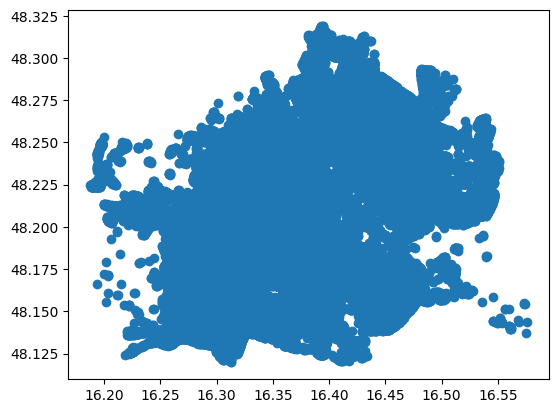

In [5]:
import pandas as pd
import geopandas as gpd

vienna_pop_filepath = 'data/vienna_pop.parquet'
df = pd.read_parquet(vienna_pop_filepath)

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['lon'], df['lat']), crs='EPSG:4326')
gdf.plot()

<Axes: >

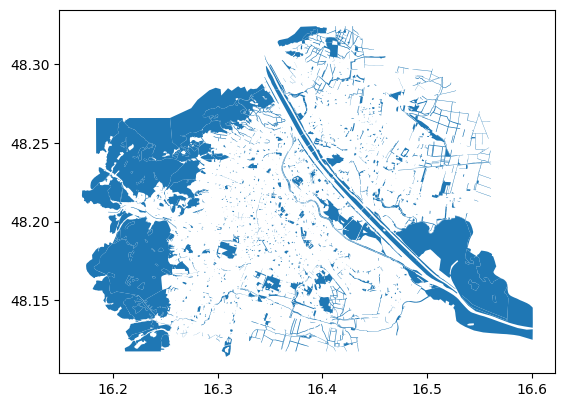

In [6]:
import geopandas as gpd

vienna_greens_file = 'data/vienna_green.json' # takes also geojson
gdf = gpd.read_file(vienna_greens_file)
gdf.plot()

<Axes: >

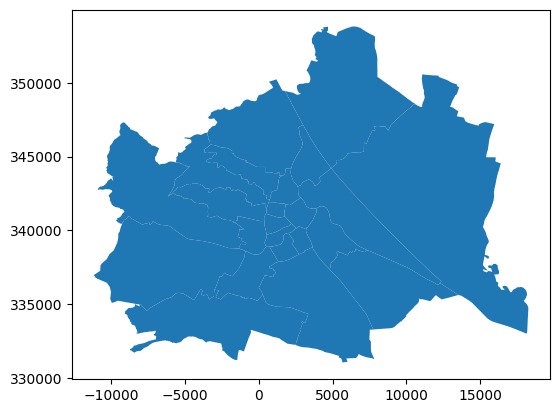

In [7]:
import geopandas as gpd

vienna_districts_file = 'data/vienna_districts.zip' # takes also shapefile
gdf = gpd.read_file(vienna_districts_file) 
gdf.plot()

<Axes: >

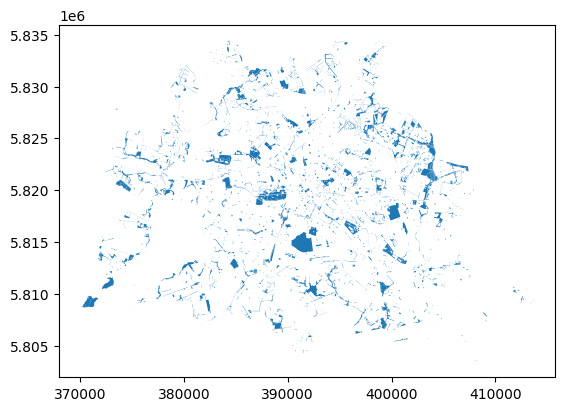

In [8]:
import geopandas as gpd

berlin_greens_wfs = 'https://fbinter.stadt-berlin.de/fb/wfs/data/senstadt/s_gruenanlagenbestand?service=WFS&version=2.0.0&request=GetFeature&outputFormat=application/json&typeNames=fis:s_gruenanlagenbestand'
gdf = gpd.read_file(berlin_greens_wfs)
gdf.plot()

### 🎡 Vienna

In [5]:
# initialize data and class

# define file paths
vienna_pop_file = 'data/vienna_pop.parquet'
vienna_districts_file = 'data/vienna_districts.zip'
vienna_greens_file = 'data/vienna_green.json'

# initialize analysis class
vienna_analysis = CityGreenSpaceAnalysis(
    city_name='Vienna',
    buffer_distance=500  # meters
)

In [6]:
# load data
try:
    gdf_districts_vienna = vienna_analysis.load_data(vienna_districts_file)
    
    gdf_pop_vienna = vienna_analysis.load_data(vienna_pop_file, colx='lon', coly='lat')
    gdf_pop_vienna = gpd.clip(gdf_pop_vienna, gdf_districts_vienna['geometry'].unary_union) # preparation
    
    gdf_green_vienna = vienna_analysis.load_data(vienna_greens_file)
    gdf_green_vienna = gpd.clip(gdf_green_vienna, gdf_districts_vienna['geometry'].unary_union) # preparation

    logger.info(f"done.")

except (FileNotFoundError, ValueError) as e:
    logger.critical(f"Data loading failed: {e}")
    raise

2024-10-22 14:25:11,655 [INFO] Loading data for ('Vienna',) from data/vienna_districts.zip...
2024-10-22 14:25:11,989 [INFO] Loaded GeoDataFrame with 23 records.
2024-10-22 14:25:11,989 [INFO] Loading data for ('Vienna',) from data/vienna_pop.parquet...
2024-10-22 14:25:12,638 [INFO] Loaded Parquet file with 171443 records.
2024-10-22 14:25:12,816 [INFO] Loading data for ('Vienna',) from data/vienna_green.json...
2024-10-22 14:25:13,075 [INFO] Loaded GeoDataFrame with 1936 records.
2024-10-22 14:25:13,699 [INFO] done.


2024-10-21 11:39:30,889 [INFO] Plotting overlay of districts, green spaces, and population points.


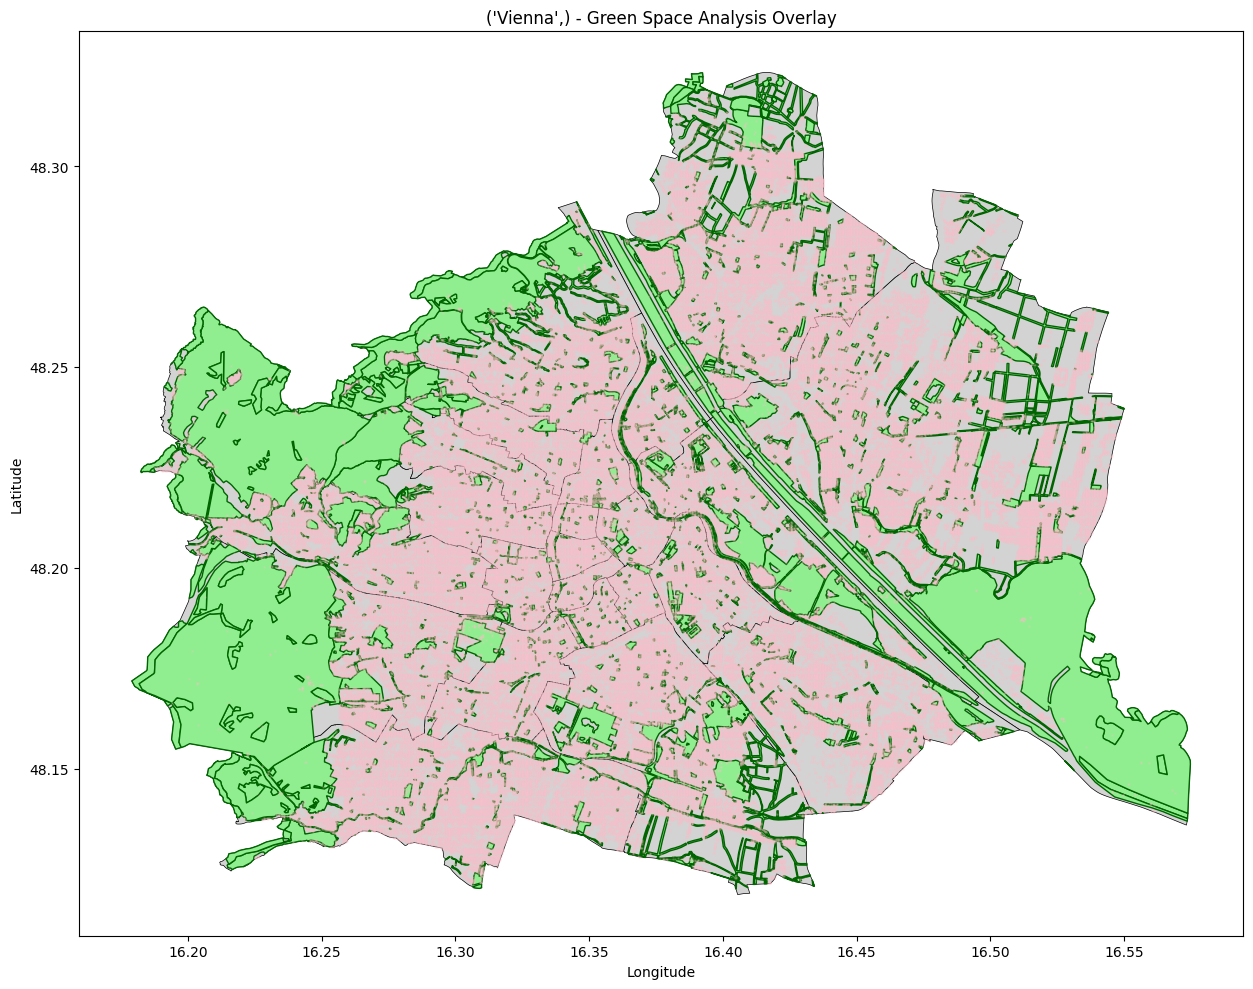

In [11]:
# initial overlay plot
vienna_analysis.plot_overlay(gdf_districts_vienna, gdf_green_vienna, gdf_pop_vienna, 15, 10)

In [7]:
# create interactive map with Kepler

# create map 
kepler_map = KeplerGl()
# center the map on the data
kepler_map.config['mapState'] = {
            'latitude': gdf_pop_vienna.iloc[0].lat,
            'longitude': gdf_pop_vienna.iloc[0].lon,
            'zoom': 12
}

# calculate green spaces areas
gdf_green_vienna['area'] = gdf_green_vienna.set_geometry('geometry').to_crs('EPSG:3857').area*1e-6

# add data to the map
kepler_map.add_data(data= gdf_pop_vienna[['pop', 'geometry']], name='pop_vienna')
kepler_map.add_data(data=gdf_green_vienna, name='greens')

# save to html
kepler_map.save_to_html(file_name='explore_map.html', config=kepler_map.config)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to explore_map.html!


In [8]:
# open the html in jupyter
IFrame(src='./explore_map.html', width=800, height=800)

In [14]:
# prepare data

# Rename columns to match required schema
gdf_districts_vienna = gdf_districts_vienna.rename(columns={'BEZ': 'district_id', 'NAMEK': 'district_name'})
gdf_green_vienna = gdf_green_vienna.rename(columns={'OBJECTID': 'green_id'})
gdf_pop_vienna = gdf_pop_vienna.rename(columns={'aut_general_2020': 'pop', 'longitude': 'lon', 'latitude': 'lat'})

In [15]:
# run density analysis
try:
    gdf_vienna_output = vienna_analysis.run_density_analysis(
        gdf_districts=gdf_districts_vienna,
        gdf_greens=gdf_green_vienna,
        gdf_pop=gdf_pop_vienna
    )
except ValueError as e:
    logger.critical(f"Analysis failed: {e}")
    raise

2024-10-21 11:40:10,701 [INFO] Buffered green spaces with distance 500 meters.
2024-10-21 11:40:16,045 [INFO] Determined proximity of population points to green spaces.
2024-10-21 11:40:16,066 [INFO] Aggregated population data by district.
2024-10-21 11:40:16,082 [INFO] Normalized population data and calculated density metrics.
2024-10-21 11:40:16,083 [INFO] Analysis completed successfully.


2024-10-21 12:01:50,911 [INFO] Visualizing analysis results.


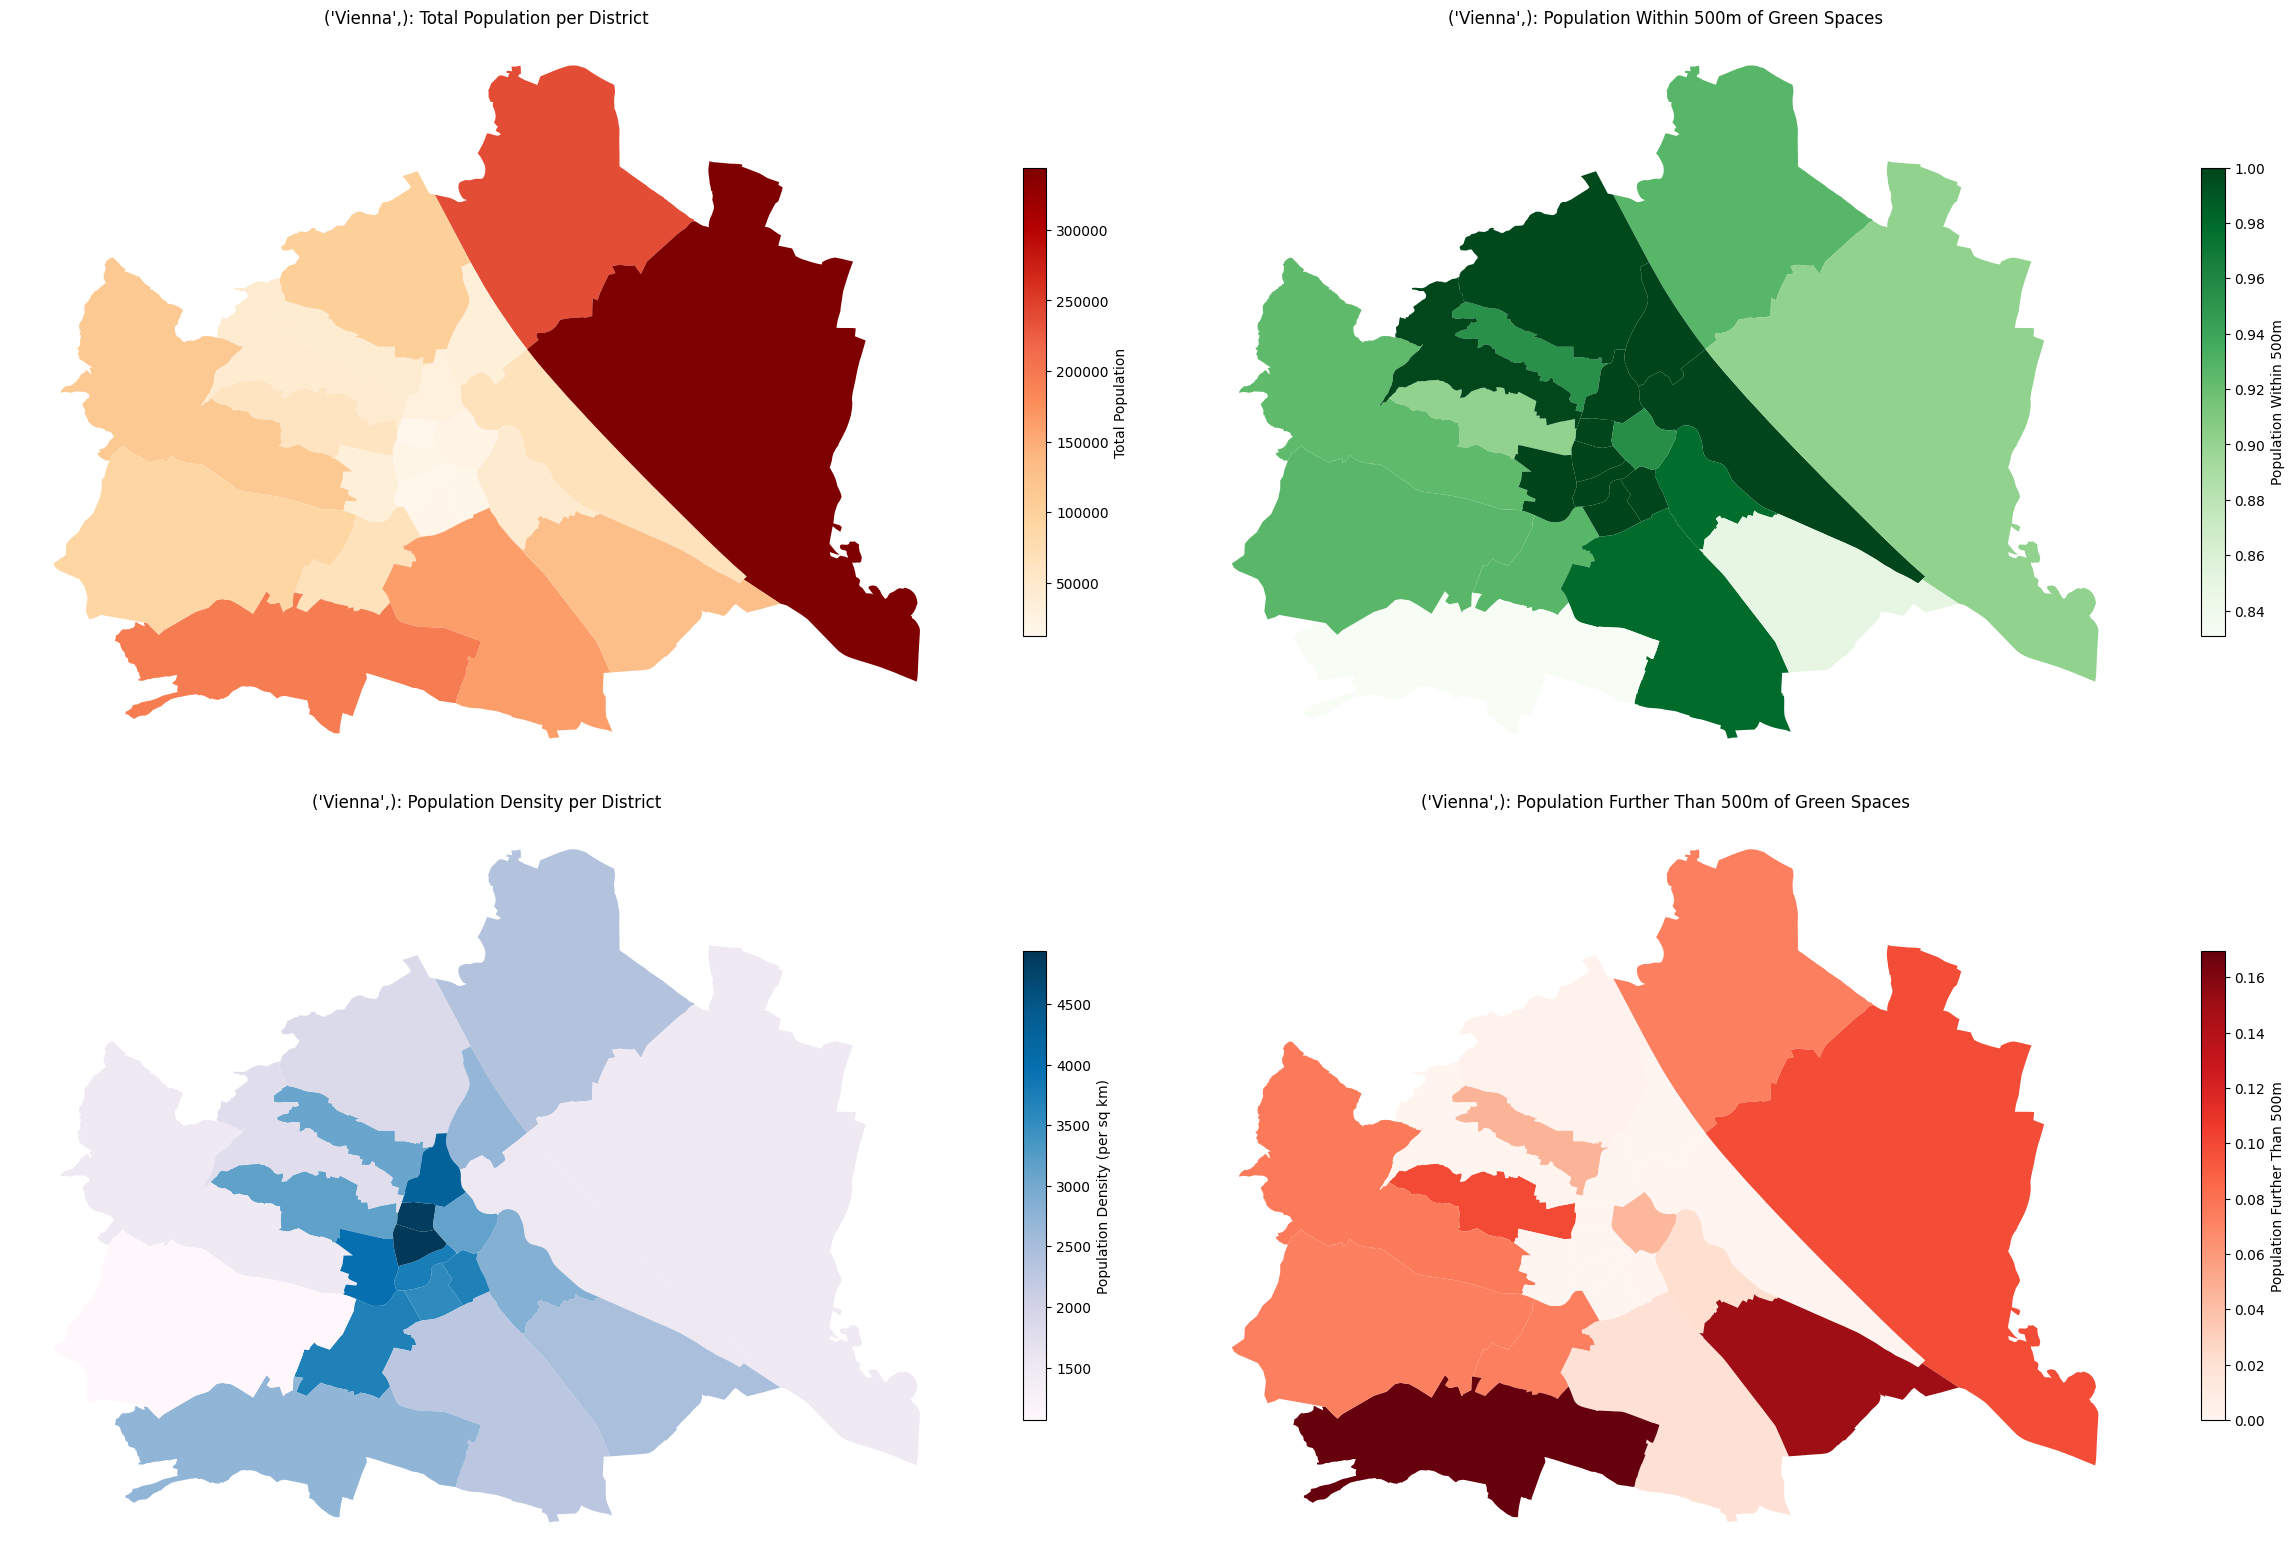

In [37]:
# visualize results
vienna_analysis.visualize_density_results(gdf_vienna_output)

2024-10-08 15:31:28,308 [INFO] Creating stacked bar chart for population distribution.


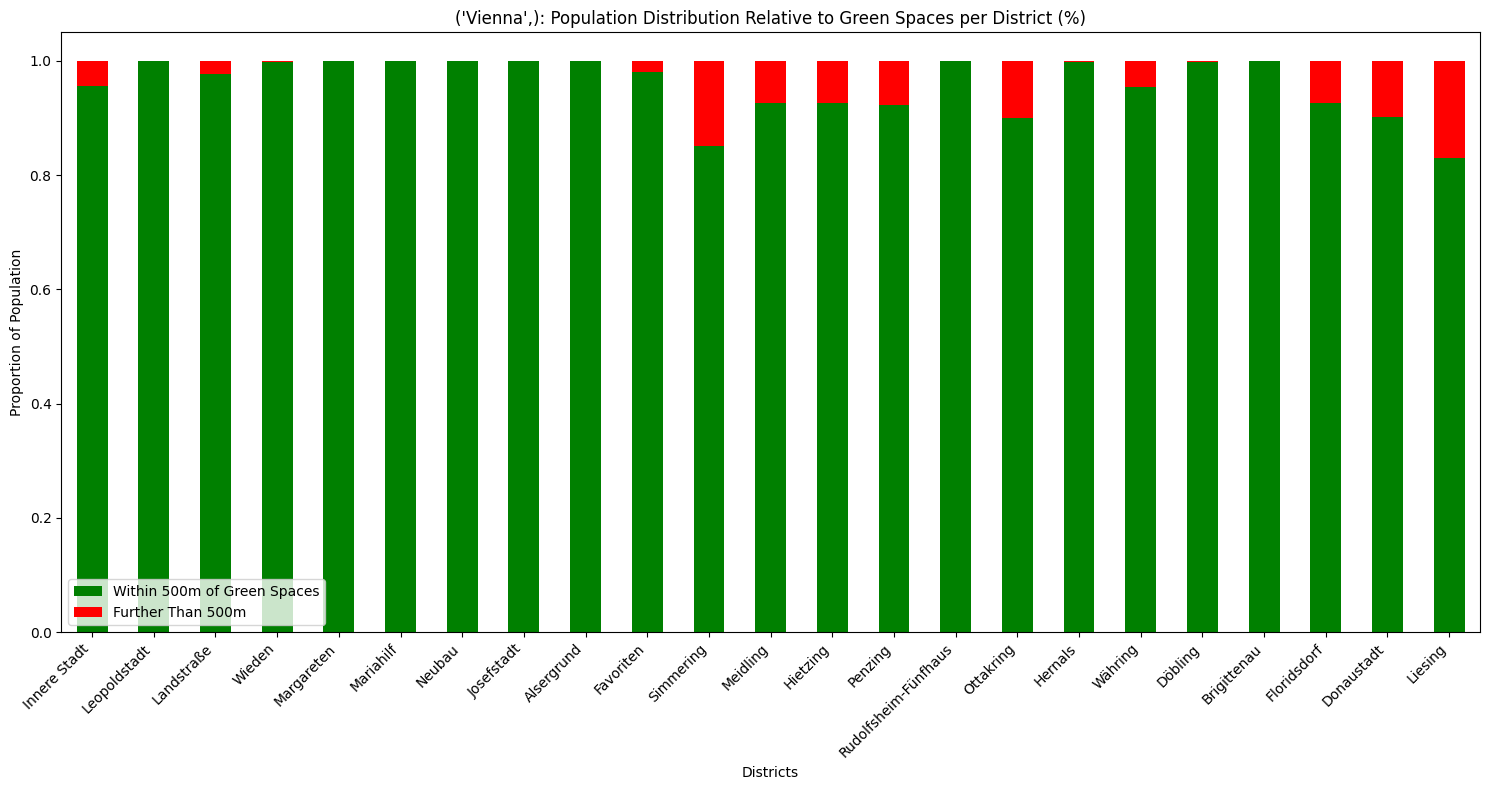

In [121]:
# create stacked bar chart
vienna_analysis.create_stacked_bar_chart(gdf_vienna_output)

##### 2SFCA analysis

In [24]:
# Run 2SFCA analysis
try:
    gdf_vienna_output = vienna_analysis.run_2sfca_analysis(
        gdf_districts=gdf_districts_vienna,
        gdf_greens=gdf_green_vienna,
        gdf_pop=gdf_pop_vienna
    )
except ValueError as e:
    logger.critical(f"Analysis failed: {e}")
    raise

2024-10-09 08:48:57,276 [INFO] Added 'pop_id' column to population GeoDataFrame.
2024-10-09 08:48:57,521 [INFO] Buffered green spaces with distance 500 meters.
2024-10-09 08:48:58,362 [INFO] Calculating total population within each green space buffer.
2024-10-09 08:49:11,132 [INFO] Calculated supply-to-demand ratio for green spaces.
2024-10-09 08:49:11,133 [INFO] Aggregating accessibility scores for each district.
2024-10-09 08:49:11,436 [INFO] Aggregated accessibility scores by district.
2024-10-09 08:49:11,441 [INFO] Two-Step Floating Catchment Area (2SFCA) analysis completed successfully.


2024-10-09 08:49:14,283 [INFO] Visualizing accessibility scores across districts.


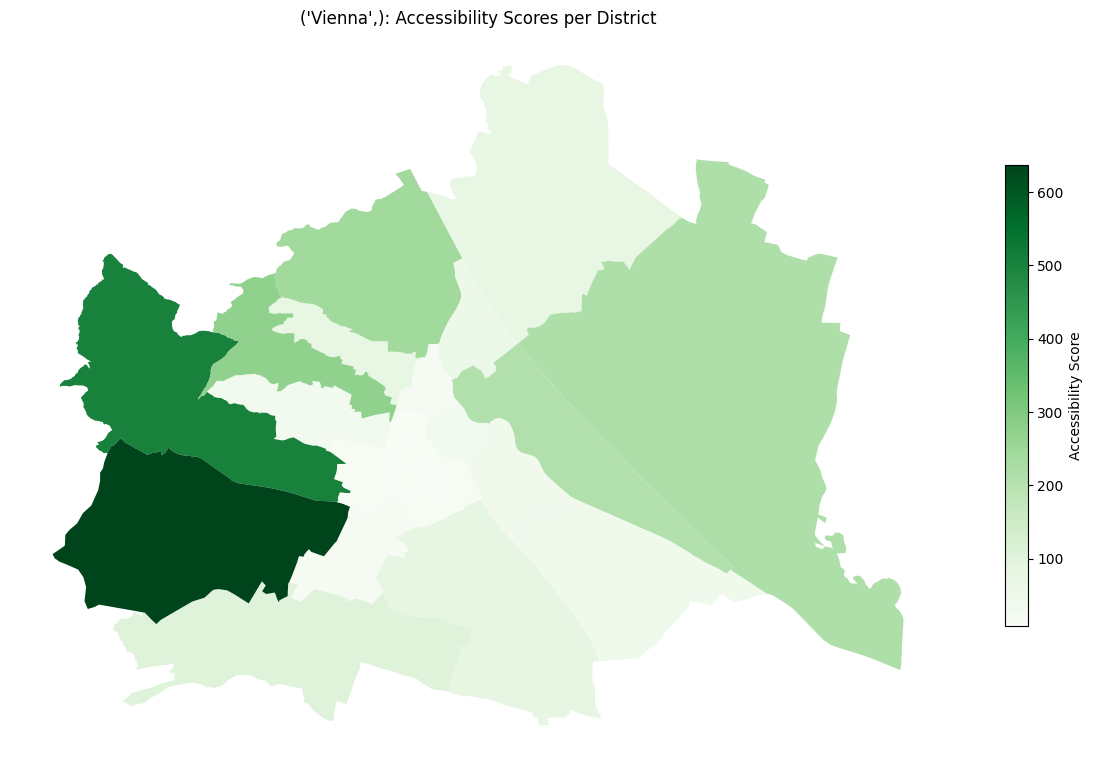

In [25]:
# visualize results
vienna_analysis.visualize_accessibility(gdf_vienna_output)

### 🥨 Berlin

In [45]:
# init

# define file paths
berlin_pop_file = 'data/berlin_pop.parquet'
berlin_districts_file = 'data/berlin_districts.geojson'
berlin_greens_wfs = 'https://fbinter.stadt-berlin.de/fb/wfs/data/senstadt/s_gruenanlagenbestand?service=WFS&version=2.0.0&request=GetFeature&outputFormat=application/json&typeNames=fis:s_gruenanlagenbestand'

# initialize analysis class
berlin_analysis = CityGreenSpaceAnalysis(
    city_name='Berlin',
    buffer_distance=500  # meters
)

In [46]:
# load data
try:
    gdf_districts_berlin = berlin_analysis.load_data(berlin_districts_file)
    
    gdf_pop_berlin = berlin_analysis.load_data(berlin_pop_file, colx='lon', coly='lat')
    gdf_pop_berlin = gpd.clip(gdf_pop_berlin, gdf_districts_berlin['geometry'].unary_union) # preparation

    gdf_green_berlin = berlin_analysis.load_data(berlin_greens_wfs)
    gdf_green_berlin = gpd.clip(gdf_green_berlin, gdf_districts_berlin['geometry'].unary_union) # preparation

    logger.info(f"done.")
except (FileNotFoundError, ValueError) as e:
    logger.critical(f"Data loading failed: {e}")
    raise

2024-10-14 16:16:03,980 [INFO] Loading data for ('Berlin',) from data/berlin_districts.geojson...
2024-10-14 16:16:04,045 [INFO] Loaded GeoDataFrame with 12 records.
2024-10-14 16:16:04,046 [INFO] Loading data for ('Berlin',) from data/berlin_pop.parquet...
2024-10-14 16:16:05,449 [INFO] Loaded Parquet file with 333637 records.
2024-10-14 16:16:05,670 [INFO] Loading data for ('Berlin',) from https://fbinter.stadt-berlin.de/fb/wfs/data/senstadt/s_gruenanlagenbestand?service=WFS&version=2.0.0&request=GetFeature&outputFormat=application/json&typeNames=fis:s_gruenanlagenbestand...
2024-10-14 16:16:43,977 [WARNING] Invalid geometries detected and corrected.
2024-10-14 16:16:43,980 [INFO] Loaded GeoDataFrame with 2544 records.
2024-10-14 16:16:44,467 [INFO] done.


2024-10-09 08:45:04,271 [INFO] Plotting overlay of districts, green spaces, and population points.


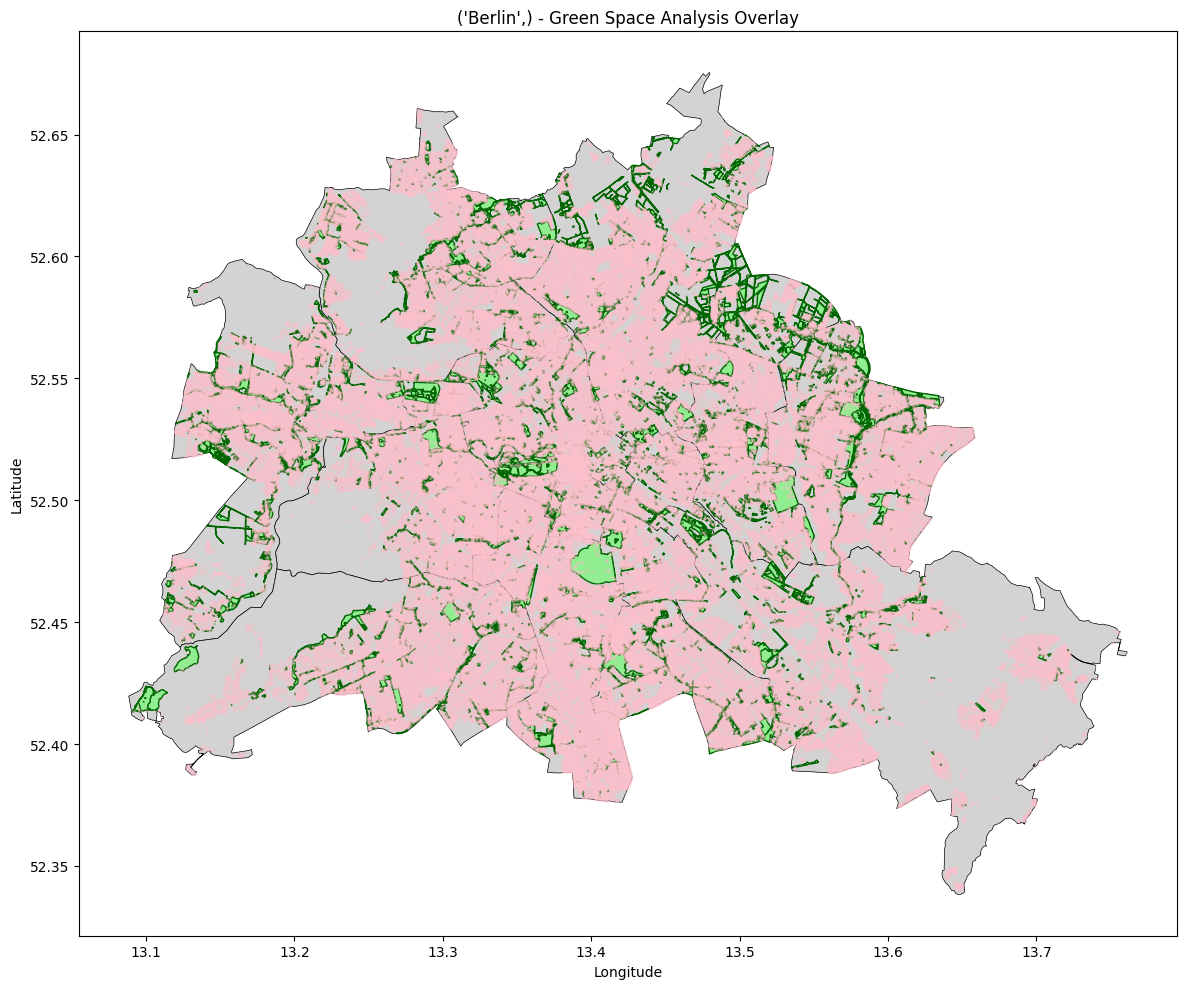

In [11]:
# initial overlay plot
berlin_analysis.plot_overlay(gdf_districts_berlin, gdf_green_berlin, gdf_pop_berlin, 15, 10)

In [50]:
# You can also interactively visualize the data with lonboard

# You need to create a color range for the data you want to visualize
colors = apply_continuous_cmap(gdf_pop_berlin['pop']/gdf_pop_berlin['pop'].max(), palcol.scientific.diverging.Berlin_20)

layer = ScatterplotLayer.from_geopandas(
    gdf_pop_berlin, billboard= True, get_fill_color=colors, get_radius = 5
)

m = Map(layer, _height=800)

m

Map(custom_attribution='', layers=(ScatterplotLayer(billboard=True, get_fill_color=arro3.core.ChunkedArray<Fix…

In [12]:
# prepare the data

# rename columns to match required schema
gdf_districts_berlin['district_id'] = gdf_districts_berlin['tags'].apply(lambda x: x.get('ref', None))

gdf_districts_berlin = gdf_districts_berlin.rename(columns={'name': 'district_name'})
gdf_green_berlin = gdf_green_berlin.rename(columns={'kennzeich': 'green_id'})
gdf_pop_berlin = gdf_pop_berlin.rename(columns={'Population': 'pop', 'Lon': 'lon', 'Lat': 'lat'})

In [13]:
# run density analysis
try:
    gdf_berlin_output = berlin_analysis.run_density_analysis(
        gdf_districts=gdf_districts_berlin,
        gdf_greens=gdf_green_berlin,
        gdf_pop=gdf_pop_berlin
    )
except ValueError as e:
    logger.critical(f"Analysis failed: {e}")
    raise

2024-10-09 08:45:23,926 [INFO] Buffered green spaces with distance 500 meters.
2024-10-09 08:45:33,417 [INFO] Determined proximity of population points to green spaces.
2024-10-09 08:45:33,450 [INFO] Aggregated population data by district.
2024-10-09 08:45:33,455 [INFO] Normalized population data and calculated density metrics.
2024-10-09 08:45:33,455 [INFO] Analysis completed successfully.


2024-10-09 08:45:37,496 [INFO] Visualizing analysis results.


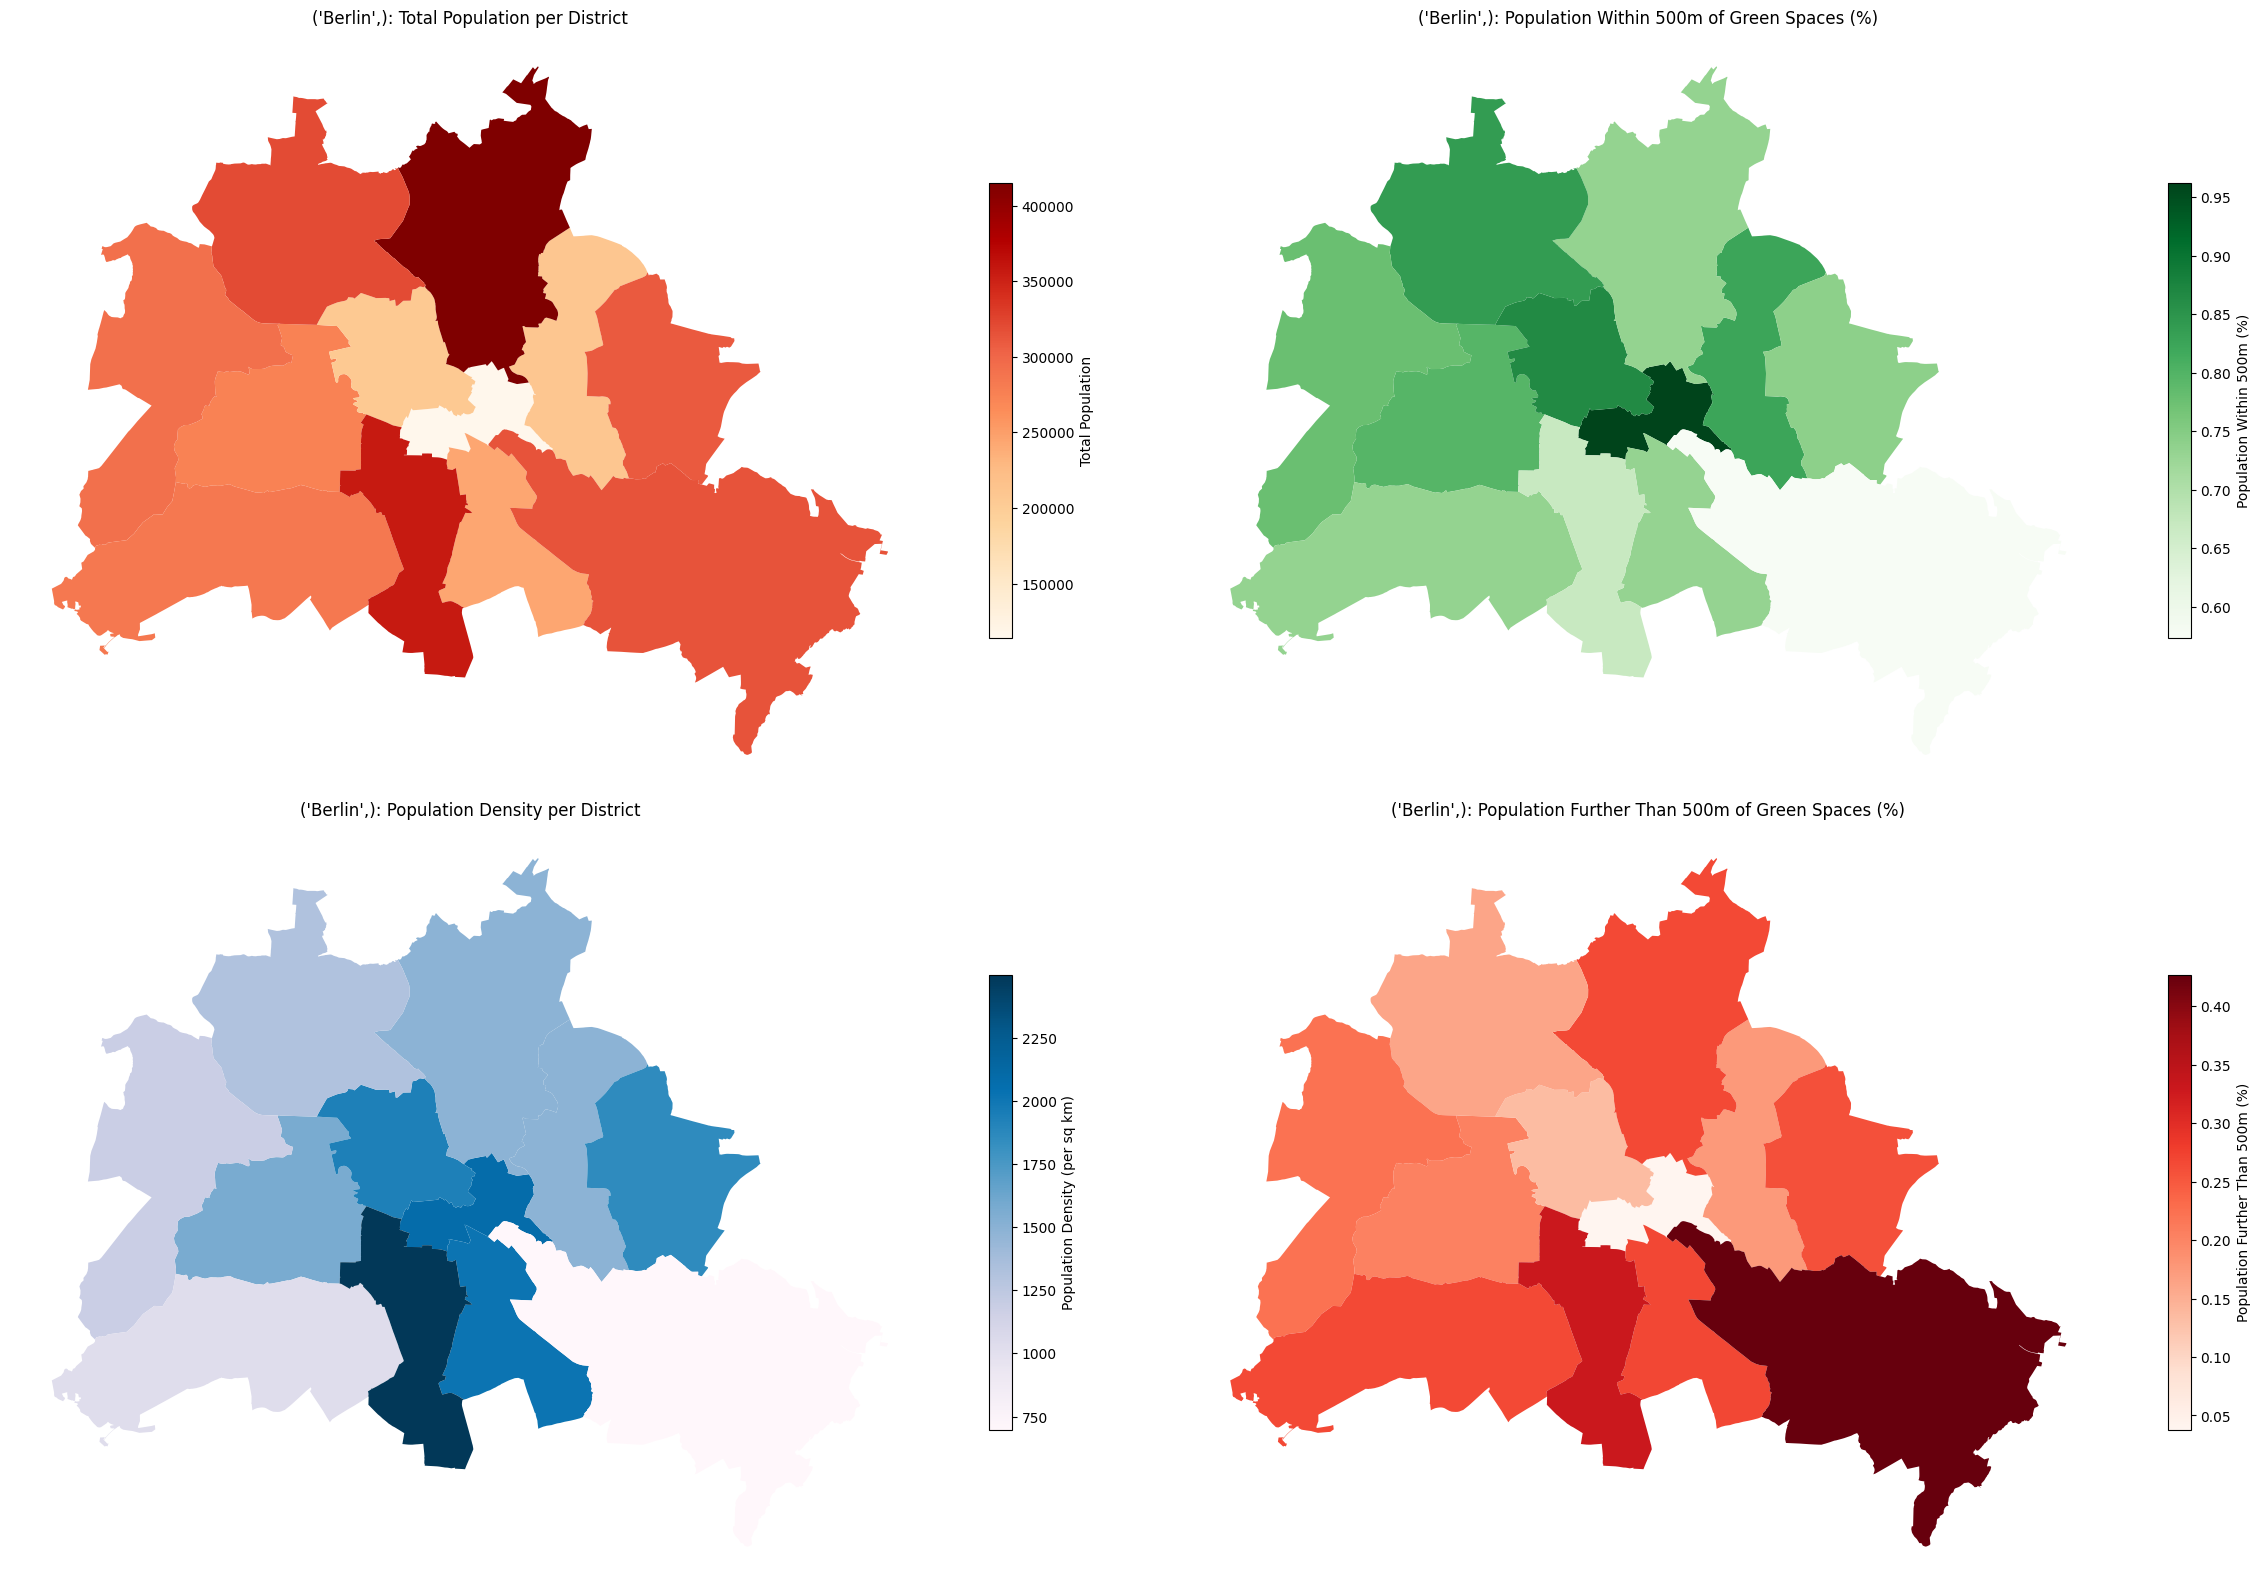

In [14]:
# visualize results
berlin_analysis.visualize_density_results(gdf_berlin_output)

2024-10-09 08:45:41,168 [INFO] Creating stacked bar chart for population distribution.


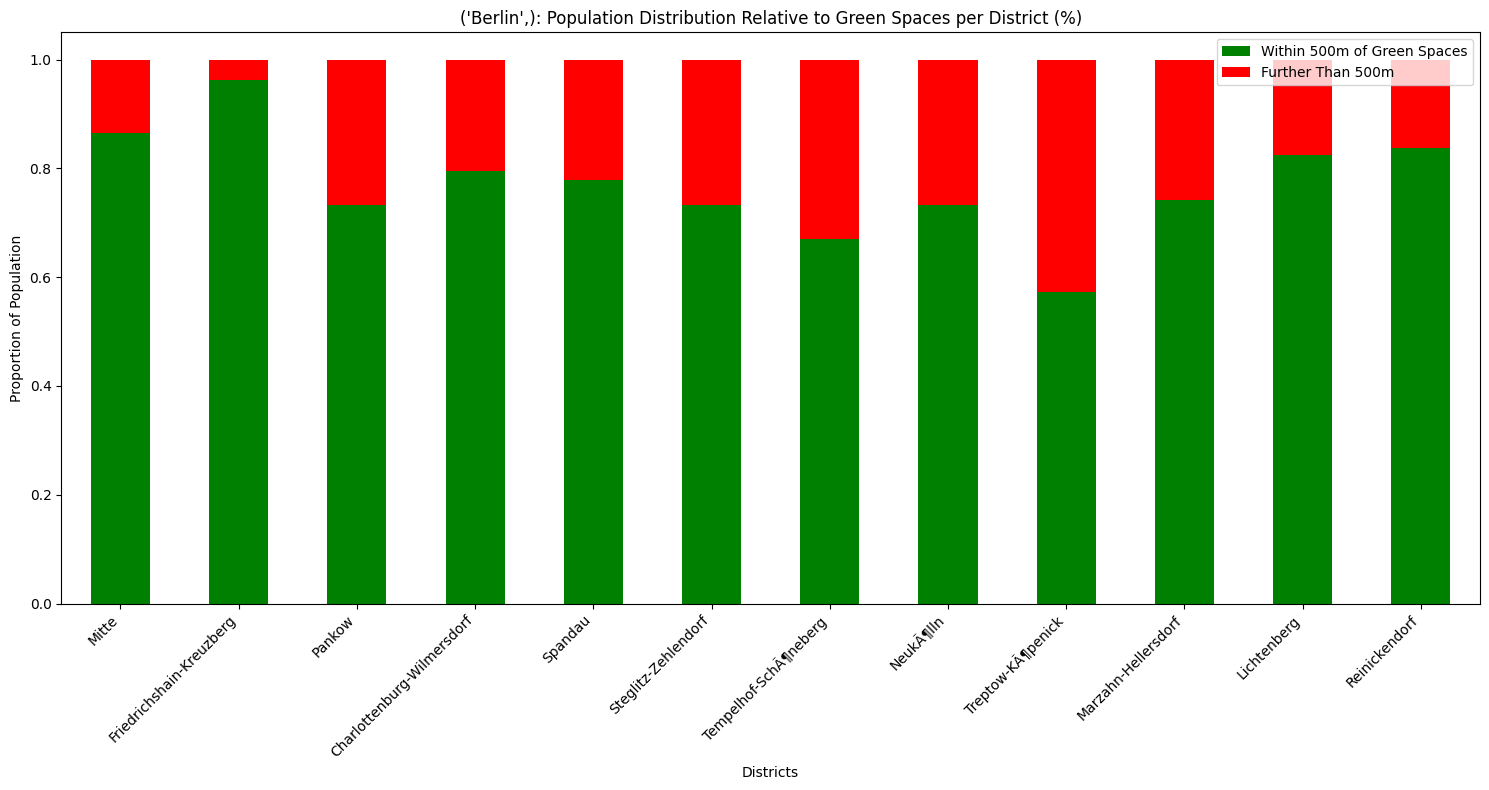

In [15]:
# create stacked bar chart
berlin_analysis.create_stacked_bar_chart(gdf_berlin_output)

##### 2SFCA analysis

In [16]:
# Run 2SFCA analysis
try:
    gdf_berlin_output = berlin_analysis.run_2sfca_analysis(
        gdf_districts=gdf_districts_berlin,
        gdf_greens=gdf_green_berlin,
        gdf_pop=gdf_pop_berlin
    )
except ValueError as e:
    logger.critical(f"Analysis failed: {e}")
    raise

2024-10-09 08:45:44,398 [INFO] Added 'pop_id' column to population GeoDataFrame.
2024-10-09 08:45:45,321 [INFO] Buffered green spaces with distance 500 meters.
2024-10-09 08:45:45,797 [INFO] Calculating total population within each green space buffer.
2024-10-09 08:46:53,130 [INFO] Calculated supply-to-demand ratio for green spaces.
2024-10-09 08:46:53,130 [INFO] Aggregating accessibility scores for each district.
2024-10-09 08:46:53,723 [INFO] Aggregated accessibility scores by district.
2024-10-09 08:46:53,736 [INFO] Two-Step Floating Catchment Area (2SFCA) analysis completed successfully.


2024-10-09 08:47:07,717 [INFO] Visualizing accessibility scores across districts.


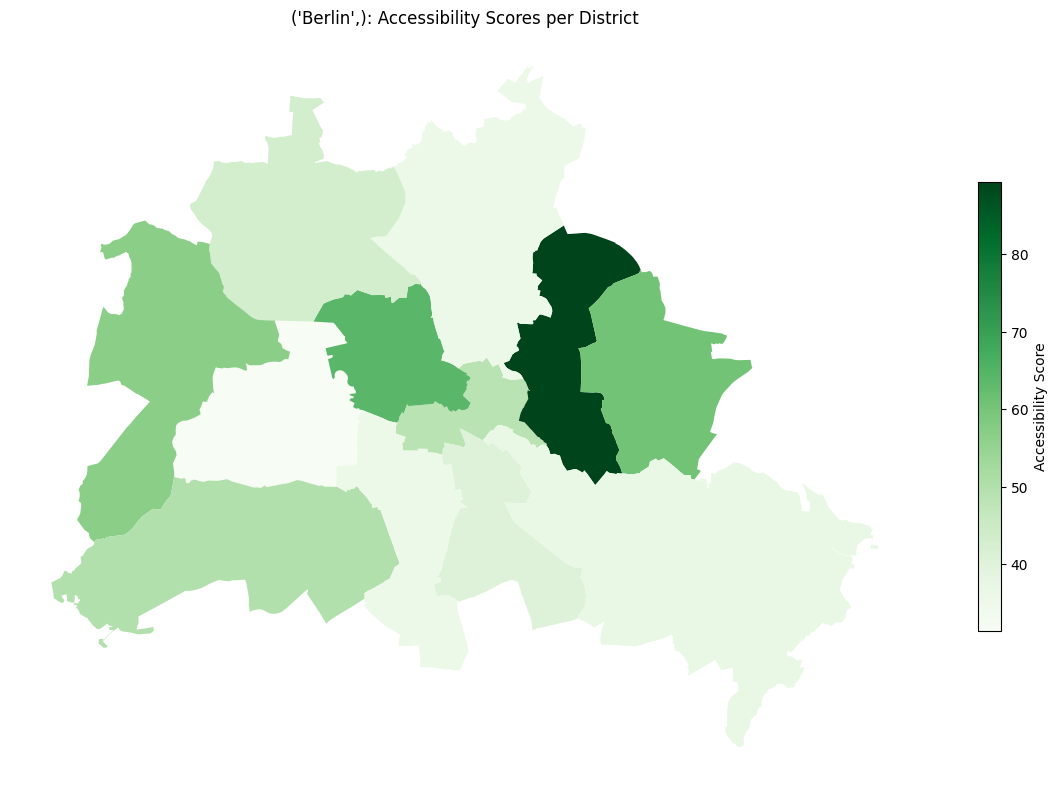

In [18]:
# visualize results
berlin_analysis.visualize_accessibility(gdf_berlin_output)